# Metrics

In [1]:
path_to_dataset = "/Users/arturgimranov/CS/fourth_year/dla_course/ss/data/datasets/librispeech"

In [2]:
import os
import glob
from glob import glob

import numpy as np

import random

import librosa
import soundfile as sf
import pyloudnorm as pyln
import matplotlib.pyplot as plt

import torch
from torchmetrics.audio import SignalDistortionRatio, ScaleInvariantSignalDistortionRatio
from IPython import display

from concurrent.futures import ProcessPoolExecutor
import warnings
warnings.filterwarnings("ignore")

/Users/arturgimranov/CS/fourth_year/dla_course/ss/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


There are three main scores to evaluate source to noise ratio:

- SNR(Signal-To-Noise Ratio).
\begin{gather*}
    SNR(s, \hat{s}) = 10 \log_{10}{\|s\|^2 \over \|s - \hat{s}\|^2}
\end{gather*}

- SDR(Signal-To-Distortion Ratio, https://inria.hal.science/inria-00544230/document).
For decomposition
\begin{gather*}
    \hat{s} = s + \varepsilon^{\rm{spat}} + \varepsilon^{\rm{interf}} + \varepsilon^{\rm{artif}}
\end{gather*}
the SDR score looks like
\begin{gather*}
    SDR(\hat{s}, s) = 10 \log_{10}{\|\hat{s}\|^2 \over \|\varepsilon^{\rm{spat}} + \varepsilon^{\rm{artif}}\|^2}
\end{gather*}


- SI-SDR(Scale-Invariant Signal-To-Distortion Ratio, https://browse.arxiv.org/pdf/1811.02508.pdf).
\begin{gather*}
    SI\text{-}SDR(\hat{s}, s) = 10 \log_{10}{\|{\hat{s}^T s \over \|s\|^2}s\|^2 \over \|{\hat{s}^T s \over \|s\|^2}s - \hat{s}\|^2}
\end{gather*}

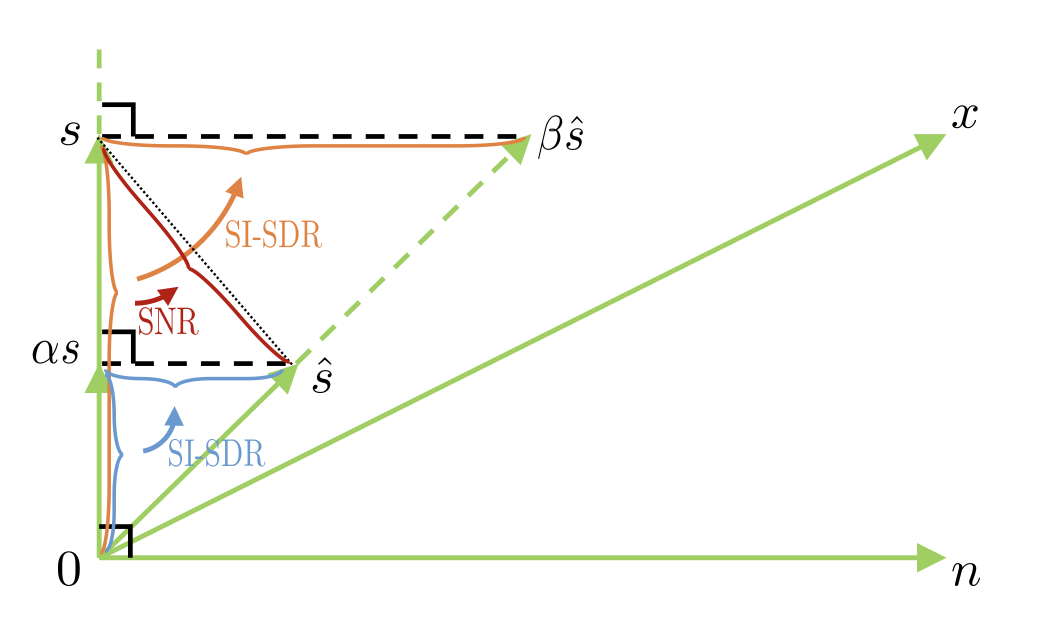

In [3]:
def snr(est, target):
    return 20 * np.log10(np.linalg.norm(target) / (np.linalg.norm(target - est) + 1e-6) + 1e-6)

def si_sdr(est, target):
    alpha = (target * est).sum() / np.linalg.norm(target)**2
    return 20 * np.log10(np.linalg.norm(alpha * target) / (np.linalg.norm(alpha * target - est) + 1e-6) + 1e-6)

In [4]:
target, _ = sf.read('/Users/arturgimranov/CS/fourth_year/dla_course/ss/data/datasets/librispeech/dev-clean/84/121123/84-121123-0000.flac')
noise, _ = sf.read('/content/Vacuum2.wav')

meter = pyln.Meter(16000) # create BS.1770 meter

louds = meter.integrated_loudness(noise)
noise = pyln.normalize.loudness(noise, louds, -29)

LibsndfileError: Error opening '/content/Vacuum2.wav': System error.

In [ ]:
length = min(len(target), len(noise))

target = target[:length]
noise = noise[:length]
s1 = target + noise
display.display(display.Audio(s1, rate=16000))

#Compute SNR

snr_val = snr(s1, target)
print(snr_val)

In [ ]:
s2 = (target + noise) * 10
display.display(display.Audio(s2, rate=16000))

snr_val = snr(s2, target)
print(snr_val)

In [ ]:
sdr = SignalDistortionRatio()

print("SDR for s1:", sdr(torch.from_numpy(s1), torch.from_numpy(target)).item())
print("SDR for s2:", sdr(torch.from_numpy(s2), torch.from_numpy(target)).item())
print("SI-SDR for s1:", si_sdr(s1, target))
print("SI-SDR for s2:", si_sdr(s2, target))

In [ ]:
n_fft = 1024
window_size = n_fft
hop_size = 256
window = torch.hann_window(window_size)

spectrum = torch.stft(
    torch.from_numpy(s1),
    n_fft=n_fft,
    hop_length=hop_size,
    win_length=window_size,
    window=window,
    center=False,
    onesided=True,
    return_complex=False,
)

In [ ]:
spectrogram = spectrum.norm(dim=-1).pow(2)

plt.figure(figsize=(20, 5))
plt.imshow(spectrogram.squeeze().log())
plt.xlabel('Time', size=20)
plt.ylabel('Frequency (Hz)', size=20)
plt.show()

![](https://i.imgur.com/HRIVdDC.jpg)

# Audios Mixer

In [ ]:
def snr_mixer(clean, noise, snr):
    amp_noise = np.linalg.norm(clean) / 10**(snr / 20)

    noise_norm = (noise / np.linalg.norm(noise)) * amp_noise

    mix = clean + noise_norm

    return mix

def vad_merge(w, top_db):
    intervals = librosa.effects.split(w, top_db=top_db)
    temp = list()
    for s, e in intervals:
        temp.append(w[s:e])
    return np.concatenate(temp, axis=None)

def cut_audios(s1, s2, sec, sr):
    cut_len = sr * sec
    len1 = len(s1)
    len2 = len(s2)

    s1_cut = []
    s2_cut = []

    segment = 0
    while (segment + 1) * cut_len < len1 and (segment + 1) * cut_len < len2:
        s1_cut.append(s1[segment * cut_len:(segment + 1) * cut_len])
        s2_cut.append(s2[segment * cut_len:(segment + 1) * cut_len])

        segment += 1

    return s1_cut, s2_cut

def fix_length(s1, s2, min_or_max='max'):
    # Fix length
    if min_or_max == 'min':
        utt_len = np.minimum(len(s1), len(s2))
        s1 = s1[:utt_len]
        s2 = s2[:utt_len]
    else:  # max
        utt_len = np.maximum(len(s1), len(s2))
        s1 = np.append(s1, np.zeros(utt_len - len(s1)))
        s2 = np.append(s2, np.zeros(utt_len - len(s2)))
    return s1, s2

In [ ]:
def create_mix(idx, triplet, snr_levels, out_dir, test=False, sr=16000, **kwargs):
    trim_db, vad_db = kwargs["trim_db"], kwargs["vad_db"]
    audioLen = kwargs["audioLen"]

    s1_path = triplet["target"]
    s2_path = triplet["noise"]
    ref_path = triplet["reference"]
    target_id = triplet["target_id"]
    noise_id = triplet["noise_id"]

    s1, _ = sf.read(os.path.join('', s1_path))
    s2, _ = sf.read(os.path.join('', s2_path))
    ref, _ = sf.read(os.path.join('', ref_path))

    meter = pyln.Meter(sr) # create BS.1770 meter

    louds1 = meter.integrated_loudness(s1)
    louds2 = meter.integrated_loudness(s2)
    loudsRef = meter.integrated_loudness(ref)

    s1Norm = pyln.normalize.loudness(s1, louds1, -29)
    s2Norm = pyln.normalize.loudness(s2, louds2, -29)
    refNorm = pyln.normalize.loudness(ref, loudsRef, -23.0)

    amp_s1 = np.max(np.abs(s1Norm))
    amp_s2 = np.max(np.abs(s2Norm))
    amp_ref = np.max(np.abs(refNorm))

    if amp_s1 == 0 or amp_s2 == 0 or amp_ref == 0:
        return

    if trim_db:
        ref, _ = librosa.effects.trim(refNorm, top_db=trim_db)
        s1, _ = librosa.effects.trim(s1Norm, top_db=trim_db)
        s2, _ = librosa.effects.trim(s2Norm, top_db=trim_db)

    if len(ref) < sr:
        return

    path_mix = os.path.join(out_dir, f"{target_id}_{noise_id}_" + "%06d" % idx + "-mixed.wav")
    path_target = os.path.join(out_dir, f"{target_id}_{noise_id}_" + "%06d" % idx + "-target.wav")
    path_ref = os.path.join(out_dir, f"{target_id}_{noise_id}_" + "%06d" % idx + "-ref.wav")

    snr = np.random.choice(snr_levels, 1).item()

    if not test:
        s1, s2 = vad_merge(s1, vad_db), vad_merge(s2, vad_db)
        s1_cut, s2_cut = cut_audios(s1, s2, audioLen, sr)

        for i in range(len(s1_cut)):
            mix = snr_mixer(s1_cut[i], s2_cut[i], snr)

            louds1 = meter.integrated_loudness(s1_cut[i])
            s1_cut[i] = pyln.normalize.loudness(s1_cut[i], louds1, -23.0)
            loudMix = meter.integrated_loudness(mix)
            mix = pyln.normalize.loudness(mix, loudMix, -23.0)

            path_mix_i = path_mix.replace("-mixed.wav", f"_{i}-mixed.wav")
            path_target_i = path_target.replace("-target.wav", f"_{i}-target.wav")
            path_ref_i = path_ref.replace("-ref.wav", f"_{i}-ref.wav")
            sf.write(path_mix_i, mix, sr)
            sf.write(path_target_i, s1_cut[i], sr)
            sf.write(path_ref_i, ref, sr)
    else:
        s1, s2 = fix_length(s1, s2, 'max')
        mix = snr_mixer(s1, s2, snr)
        louds1 = meter.integrated_loudness(s1)
        s1 = pyln.normalize.loudness(s1, louds1, -23.0)

        loudMix = meter.integrated_loudness(mix)
        mix = pyln.normalize.loudness(mix, loudMix, -23.0)

        sf.write(path_mix, mix, sr)
        sf.write(path_target, s1, sr)
        sf.write(path_ref, ref, sr)

In [ ]:
class LibriSpeechSpeakerFiles:
    def __init__(self, speaker_id, audios_dir, audioTemplate="*-norm.wav"):
        self.id = speaker_id
        self.files = []
        self.audioTemplate=audioTemplate
        self.files = self.find_files_by_worker(audios_dir)

    def find_files_by_worker(self, audios_dir):
        speakerDir = os.path.join(audios_dir,self.id) #it is a string
        chapterDirs = os.scandir(speakerDir)
        files=[]
        for chapterDir in chapterDirs:
            files = files + [file for file in glob(os.path.join(speakerDir,chapterDir.name)+"/"+self.audioTemplate)]
        return files

In [ ]:
class MixtureGenerator:
    def __init__(self, speakers_files, out_folder, nfiles=5000, test=False, randomState=42):
        self.speakers_files = speakers_files # list of SpeakerFiles for every speaker_id
        self.nfiles = nfiles
        self.randomState = randomState
        self.out_folder = out_folder
        self.test = test
        random.seed(self.randomState)
        if not os.path.exists(self.out_folder):
            os.makedirs(self.out_folder)

    def generate_triplets(self):
        i = 0
        all_triplets = {"reference": [], "target": [], "noise": [], "target_id": [], "noise_id": []}
        while i < self.nfiles:
            spk1, spk2 = random.sample(self.speakers_files, 2)

            if len(spk1.files) < 2 or len(spk2.files) < 2:
                continue

            target, reference = random.sample(spk1.files, 2)
            noise = random.choice(spk2.files)
            all_triplets["reference"].append(reference)
            all_triplets["target"].append(target)
            all_triplets["noise"].append(noise)
            all_triplets["target_id"].append(spk1.id)
            all_triplets["noise_id"].append(spk2.id)
            i += 1

        return all_triplets

    def triplet_generator(self, target_speaker, noise_speaker, number_of_triplets):
        max_num_triplets = min(len(target_speaker.files), len(noise_speaker.files))
        number_of_triplets = min(max_num_triplets, number_of_triplets)

        target_samples = random.sample(target_speaker.files, k=number_of_triplets)
        reference_samples = random.sample(target_speaker.files, k=number_of_triplets)
        noise_samples = random.sample(noise_speaker.files, k=number_of_triplets)

        triplets = {"reference": [], "target": [], "noise": [],
                    "target_id": [target_speaker.id] * number_of_triplets, "noise_id": [noise_speaker.id] * number_of_triplets}
        triplets["target"] += target_samples
        triplets["reference"] += reference_samples
        triplets["noise"] += noise_samples

        return triplets

    def generate_mixes(self, snr_levels=[0], num_workers=10, update_steps=10, **kwargs):

        triplets = self.generate_triplets()

        with ProcessPoolExecutor(max_workers=num_workers) as pool:
            futures = []

            for i in range(self.nfiles):
                triplet = {"reference": triplets["reference"][i],
                           "target": triplets["target"][i],
                           "noise": triplets["noise"][i],
                           "target_id": triplets["target_id"][i],
                           "noise_id": triplets["noise_id"][i]}
                
                create_mix(i, triplet, snr_levels, self.out_folder, test=self.test, **kwargs)

            #     futures.append(pool.submit(create_mix, i, triplet,
            #                                snr_levels, self.out_folder,
            #                                test=self.test, **kwargs))

            # for i, future in enumerate(futures):
            #     future.result()
            #     if (i + 1) % max(self.nfiles // update_steps, 1) == 0:
            #         print(f"Files Processed | {i + 1} out of {self.nfiles}")

In [ ]:
path_train = '/Users/arturgimranov/CS/fourth_year/dla_course/ss/data/datasets/librispeech/train-clean-360'
path_val = '/Users/arturgimranov/CS/fourth_year/dla_course/ss/data/datasets/librispeech/dev-clean'

path_mixtures_train = 'train_short'
path_mixtures_val = '<val_short'

speakersTrain = [el.name for el in os.scandir(path_train)]
speakersVal = [el.name for el in os.scandir(path_val)]

speakers_files_train = [LibriSpeechSpeakerFiles(i, path_train, audioTemplate="*.flac") for i in speakersTrain]
speakers_files_val = [LibriSpeechSpeakerFiles(i, path_val, audioTemplate="*.flac") for i in speakersVal]

mixer_train = MixtureGenerator(speakers_files_train,
                                path_mixtures_train,
                                nfiles=100,
                                test=False)

mixer_val = MixtureGenerator(speakers_files_val,
                                path_mixtures_val,
                                nfiles=100,
                                test=True)

In [ ]:
mixer_train.generate_mixes(snr_levels=[-5, 5],
                           num_workers=2,
                           update_steps=100,
                           trim_db=20,
                           vad_db=20,
                           audioLen=3)

In [ ]:
mixer_val.generate_mixes(snr_levels=[-5, 5],
                           num_workers=2,
                           update_steps=100,
                           trim_db=None,
                           vad_db=20,
                           audioLen=3)

In [ ]:
train_mixes = os.listdir(path_mixtures_train)
val_mixes = os.listdir(path_mixtures_val)

In [ ]:
train_mixes[:100]

['1382_6510_000011_1-target.wav',
 '7816_6288_000052_1-ref.wav',
 '8506_764_000007_0-target.wav',
 '6060_6575_000016_1-mixed.wav',
 '1383_7933_000047_0-mixed.wav',
 '6359_1639_000077_2-ref.wav',
 '8388_1933_000065_1-target.wav',
 '2992_7558_000090_0-target.wav',
 '3001_2473_000083_2-ref.wav',
 '3945_480_000089_0-target.wav',
 '1903_6937_000073_0-ref.wav',
 '1337_984_000093_2-ref.wav',
 '7995_5293_000028_1-target.wav',
 '511_362_000003_0-mixed.wav',
 '9026_7739_000095_0-target.wav',
 '8506_764_000007_1-mixed.wav',
 '7316_2334_000078_0-target.wav',
 '548_1445_000014_1-target.wav',
 '3967_2167_000012_1-mixed.wav',
 '7286_7294_000027_2-mixed.wav',
 '5239_6509_000059_0-target.wav',
 '5635_5810_000025_0-target.wav',
 '7297_480_000061_0-mixed.wav',
 '3994_337_000074_0-ref.wav',
 '8771_6904_000075_0-mixed.wav',
 '1382_6510_000011_1-mixed.wav',
 '2388_511_000008_0-target.wav',
 '7398_6115_000054_0-mixed.wav',
 '5635_5810_000025_0-ref.wav',
 '2053_3825_000017_0-ref.wav',
 '3448_5186_000081_1-mix

In [ ]:
ref_train = sorted(glob(os.path.join(path_mixtures_train, '*-ref.wav')))
mix_train = sorted(glob(os.path.join(path_mixtures_train, '*-mixed.wav')))
target_train = sorted(glob(os.path.join(path_mixtures_train, '*-target.wav')))

In [ ]:
mix_train[:10]

['train_short/1027_5062_000068_0-mixed.wav',
 'train_short/1027_5062_000068_1-mixed.wav',
 'train_short/1027_5062_000068_2-mixed.wav',
 'train_short/1061_5935_000023_0-mixed.wav',
 'train_short/1061_5935_000023_1-mixed.wav',
 'train_short/1175_1265_000079_0-mixed.wav',
 'train_short/1175_1265_000079_1-mixed.wav',
 'train_short/1175_1265_000079_2-mixed.wav',
 'train_short/1182_6927_000057_0-mixed.wav',
 'train_short/1182_6927_000057_1-mixed.wav']

In [ ]:
target_train[:10]

['train_short/1027_5062_000068_0-target.wav',
 'train_short/1027_5062_000068_1-target.wav',
 'train_short/1027_5062_000068_2-target.wav',
 'train_short/1061_5935_000023_0-target.wav',
 'train_short/1061_5935_000023_1-target.wav',
 'train_short/1175_1265_000079_0-target.wav',
 'train_short/1175_1265_000079_1-target.wav',
 'train_short/1175_1265_000079_2-target.wav',
 'train_short/1182_6927_000057_0-target.wav',
 'train_short/1182_6927_000057_1-target.wav']

In [ ]:
ref, mix, target = ref_train[0], mix_train[0], target_train[0]

In [ ]:
from IPython import display

ref = sf.read("/Users/arturgimranov/CS/fourth_year/dla_course/ss/train_mixtures/refs/14_64_009659_0-ref.wav")[0]

In [ ]:
ref

array([0.00149536, 0.00152588, 0.00112915, ..., 0.00018311, 0.00039673,
       0.00021362])

In [ ]:
display.display(display.Audio(ref * 10, rate=16000))

In [ ]:
meter = pyln.Meter(16000)
louds_ref = meter.integrated_loudness(ref)

ref_norm = pyln.normalize.loudness(ref, louds_ref, -29)


In [ ]:
display.display(display.Audio(ref_norm, rate=16000))

In [ ]:
ref1 = sf.read("/Users/arturgimranov/CS/fourth_year/dla_course/ss/train_mixtures/refs/14_64_009659_0-ref.wav")[0]
ref2 = sf.read("/Users/arturgimranov/CS/fourth_year/dla_course/ss/train_mixtures/refs/9023_7995_008658_2-ref.wav")[0]

In [ ]:
display.display(display.Audio(ref1, rate=16000))
display.display(display.Audio(ref2, rate=16000))

In [ ]:
min_len = min(len(ref1), len(ref2))
ref1 = ref1[:min_len] * 100
ref2 = ref2[:min_len] 

mix = ref1 + ref2

display.display(display.Audio(mix, rate=16000))

In [ ]:
from IPython import display

display.display(display.Audio(ref, rate=16000))
display.display(display.Audio(mix, rate=16000))
display.display(display.Audio(target, rate=16000))

In [ ]:
ref

'train_short/1027_5062_000068_0-ref.wav'

In [ ]:
ref_vec = librosa.load(ref, sr=16000)[0]
mix_vec = librosa.load(mix, sr=16000)[0]
target_vec = librosa.load(target, sr=16000)[0]

In [ ]:
mix_vec.shape

(48000,)

In [ ]:
target_vec

array([-0.00308228, -0.00204468,  0.00048828, ...,  0.01089478,
        0.00765991,  0.00485229], dtype=float32)

In [ ]:
si_sdr(mix_vec, target_vec)

-5.00202000708014